# Neural machine translation using encoder-decoder RNN

We show how to implement NMT using an encoder-decoder.

Based on sec 9.7 of http://d2l.ai/chapter_recurrent-modern/seq2seq.html


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython import display

import jax

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

import collections
import re
import random
import os
import requests
import zipfile
import tarfile
import hashlib
import time
import functools

random.seed(0)
rng = jax.random.PRNGKey(0)

!mkdir figures # for saving plots

mkdir: cannot create directory ‘figures’: File exists


# Required functions for text preprocessing

For more details on this functions: See [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb#scrollTo=yDmK1xQ9T4IY) for details.

In [2]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [3]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract("fra-eng")
    with open(os.path.join(data_dir, "fra.txt"), "r") as f:
        return f.read()


def preprocess_nmt(text):
    """Preprocess the English-French dataset."""

    def no_space(char, prev_char):
        return char in set(",.!?") and prev_char != " "

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace("\u202f", " ").replace("\xa0", " ").lower()
    # Insert space between words and punctuation marks
    out = [" " + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return "".join(out)


def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split("\n")):
        if num_examples and i > num_examples:
            break
        parts = line.split("\t")
        if len(parts) == 2:
            source.append(parts[0].split(" "))
            target.append(parts[1].split(" "))
    return source, target


In [4]:
class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, [""] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:

reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: jnp.array(x, *args, **kwargs)


def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab[""]] for l in lines]
    array = jnp.array([truncate_pad(l, num_steps, vocab[""]) for l in lines])
    valid_len = reduce_sum(astype(array != vocab[""], jnp.int32), 1)
    return array, valid_len

In [6]:
class Dataset:
    """A dataset wrapping data arrays."""

    def __init__(self, *data_arrays):
        self.arrays = data_arrays

    def __getitem__(self, indices):
        return tuple(array[jnp.array(indices)] for array in self.arrays)

    def __len__(self):
        return self.arrays[0].shape[0]


class DataLoader:
    """A data loader with an iterable for data arrays."""

    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        return self.data_iter()

    def data_iter(self):
        indices = list(range(0, len(self.dataset)))

        if self.shuffle:
            random.shuffle(indices)

        for i in range(0, len(indices), self.batch_size):
            yield self.dataset[indices[i : i + self.batch_size]]

In [7]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a data iterator."""
    dataset = Dataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))


def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=["", "", ""])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=["", "", ""])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

# Data

We use a english-french dataset. See [this colab](https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/text_preproc_torch.ipynb#scrollTo=yDmK1xQ9T4IY) for details.

In [28]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["fra-eng"] = (DATA_URL + "fra-eng.zip", "94646ad1522d915e7b0f9296181140edcf86a4f5")

batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

# Encoder-decoder

In [29]:

class EncoderDecoder(nn.Module):
    """The encoder-decoder architecture."""

    encoder: nn.Module
    decoder: nn.Module

    @nn.compact
    def __call__(self, enc_X, dec_X, *args, deterministic=True):
        enc_outputs = self.encoder(enc_X, *args, deterministic=deterministic)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_state, dec_X, deterministic=deterministic)

## GRU

We create a multilayer GRU RNN. The hidden state of a layer, followed by dropout, is the input to the next layer.


In [30]:
class GRU(nn.Module):
    """Multi-layer GRU with dropout, scanned over the time axis."""
    num_layers: int = 1
    dropout_rate: float = 0.0
    deterministic: bool = True

    @functools.partial(
        nn.transforms.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False, "dropout": True},
    )
    @nn.compact
    def __call__(self, state, x):
        """
        Args:
          state: array of shape (num_layers, batch_size, hidden_size)
          x:     array of shape (batch_size, input_size)
        Returns:
          new_state: array of shape (num_layers, batch_size, hidden_size)
          output:    array of shape (batch_size, hidden_size)
        """
        new_states = []

        # First num_layers-1 cells with dropout after each
        for i in range(self.num_layers - 1):
            s, x = nn.GRUCell(features=state.shape[-1])(state[i], x)
            new_states.append(s)
            x = nn.Dropout(rate=self.dropout_rate)(
                x, deterministic=self.deterministic
            )

        # Final layer, no dropout on its output
        s, out = nn.GRUCell(features=state.shape[-1])(state[-1], x)
        new_states.append(s)

        # stack to shape (num_layers, batch_size, hidden_size)
        return jnp.stack(new_states, axis=0), out

    def initialize_carry(self, rng, batch_dims, size):
        """
        Zero-initialize the hidden state for all layers,
        shape = (num_layers, *batch_dims, hidden_size).
        """
        # dtype matches default GRUCell carry dtype
        return jnp.zeros((self.num_layers, *batch_dims, size), dtype=jnp.float32)

## Encoder

We use a 2-level GRU for the encoder; we set the context as the final state of the GRU. The input to the GRU is the word embedding of each token.


In [31]:
class Seq2SeqEncoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""

    vocab_size: int
    embed_size: int
    num_hiddens: int
    num_layers: int
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, X, *args, deterministic=True):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_size)(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.transpose(1, 0, 2)
        rnn = GRU(num_layers=self.num_layers, dropout_rate=self.dropout_rate, deterministic=deterministic)
        state = rnn.initialize_carry(jax.random.PRNGKey(0), (X.shape[1],), self.num_hiddens)
        state, output = rnn(state, X)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        return state, output

In [32]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
batch_size = 4
num_steps = 7
X = jnp.zeros((batch_size, num_steps), dtype=jnp.int32)
encoder_params = encoder.init(rng, X)
state, output = encoder.apply(encoder_params, X)
print(output.shape)
print(state.shape)

(7, 4, 16)
(2, 4, 16)


## Decoder

We use another GRU as the decoder. The initial state is the final state of the encoder, so we must use the same number of hidden units. In addition, we pass in the context (ie final state of encoder) as input to every step of the decoder.


In [33]:
class Seq2SeqDecoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    vocab_size: int
    embed_size: int
    num_hiddens: int
    num_layers: int
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, state, X, deterministic=True):
        # X: (batch_size, num_steps)
        # 1) embed and transpose to (num_steps, batch_size, embed_size)
        X = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_size)(X)
        X = X.transpose(1, 0, 2)

        # 2) build context by repeating the last encoder hidden across time
        #    state[-1] has shape (batch_size, num_hiddens)
        #    we add a time axis then tile:
        #      state[-1][None, :, :] -> (1, batch_size, num_hiddens)
        #      tiled to           -> (num_steps, batch_size, num_hiddens)
        num_steps = X.shape[0]
        context = jnp.tile(state[-1][None, :, :], (num_steps, 1, 1))

        # 3) concatenate inputs and context along feature dim -> (num_steps, batch_size, embed+hidden)
        X_and_context = jnp.concatenate([X, context], axis=-1)

        # 4) run through our multi-layer GRU (scanned over time)
        rnn = GRU(
            num_layers=self.num_layers,
            dropout_rate=self.dropout_rate,
            deterministic=deterministic,
        )
        state, rnn_output = rnn(state, X_and_context)
        # rnn_output: (num_steps, batch_size, num_hiddens)

        # 5) project to vocabulary and transpose back -> (batch_size, num_steps, vocab_size)
        logits = nn.Dense(features=self.vocab_size)(rnn_output)
        logits = logits.transpose(1, 0, 2)

        return state, logits

    def init_state(self, enc_outputs, *args):
        # enc_outputs is a tuple (state, output) from the encoder
        # we just take the encoder’s final hidden-state array
        return enc_outputs[0]

In [34]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder.apply(encoder_params, X))
decoder_params = decoder.init(rng, state, X)
state, output = decoder.apply(decoder_params, state, X)
print(output.shape)  # (batch size, number of time steps, vocabulary size)
print(state.shape)  # (num layers, batch size, num hiddens)

(4, 7, 10)
(2, 4, 16)


# Loss function

We use cross entropy loss, but we must mask out target tokens that are just padding. We replace all outputs beyond the valid length to the target value of 0.

In [35]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen))[None, :] < valid_len[:, None]
    return jnp.where(mask, X, value)


X = jnp.array([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, jnp.array([1, 2]))

Array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)

We now use this to create a weight mask of 0s and 1s, where 0 corresponds to invalid locations. When we compute the cross entropy loss, we multiply by this weight mask, thus ignoring invalid locations.

In [36]:
def masked_softmax_cross_entropy(pred, label, valid_len):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    weights = jnp.ones(label.shape)
    weights = sequence_mask(weights, valid_len)
    label_one_hot = jax.nn.one_hot(label, num_classes=pred.shape[-1])
    unweighted_loss = optax.softmax_cross_entropy(pred, label_one_hot)
    weighted_loss = (unweighted_loss * weights).mean(axis=1)
    return weighted_loss

As an example, let us create a prediction array of all ones of size (3,4,10) and a target label array of all ones of size (3,4). We specify the valid lengths to (4,2,0). Thus the first loss should be twice the second. And the third loss should be 0.

In [37]:
masked_softmax_cross_entropy(jnp.ones((3, 4, 10)), jnp.zeros((3, 4)), jnp.array([4, 2, 0]))

Array([2.3025851, 1.1512926, 0.       ], dtype=float32)

# Training

We use teacher forcing, where the inputs to the decoder are "bos" (beginning of sentence), followed by the ground truth target tokens from the previous step, as shown below.


<img src="https://github.com/probml/probml-notebooks/blob/main/images/seq2seq.png?raw=true">



In [38]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return jnp.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [39]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [40]:
@jax.jit
def grad_clipping(grads, theta):
    """Clip the gradient."""

    def grad_update(grads):
        return jax.tree_map(lambda g: g * theta / norm, grads)

    norm = jnp.sqrt(sum(jax.tree_util.tree_leaves(jax.tree_map(lambda x: jnp.sum(x**2), grads))))
    # Update gradient if norm > theta
    # This is jax.jit compatible
    grads = jax.lax.cond(norm > theta, grad_update, lambda g: g, grads)
    return grads

In [41]:
@jax.jit
def train_step(state, batch, bos_idx, rngs):
    """Train for a single step."""
    # Make sure to get a new RNG at every step
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params):
        X, X_valid_len, Y, Y_valid_len = batch
        bos = jnp.array([bos_idx] * Y.shape[0]).reshape(-1, 1)
        dec_input = jnp.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing
        _, Y_hat = state.apply_fn({"params": params}, X, dec_input, X_valid_len, deterministic=False, rngs=rngs)
        loss = masked_softmax_cross_entropy(Y_hat, Y, Y_valid_len)
        return loss.sum()

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    grads = grad_clipping(grads, 1)
    state = state.apply_gradients(grads=grads)

    return state, loss

def train_seq2seq(state, data_iter, num_epochs, tgt_vocab, rngs):
    """Train a model for sequence to sequence."""
    animator = Animator(xlabel="epoch", ylabel="loss", xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            state, loss = train_step(state, batch, tgt_vocab[""], rngs)
            num_tokens = batch[3].sum()
            metric.add(loss, num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))

    device = jax.default_backend()
    print(f"loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} " f"tokens/sec on {device}")
    return state

In [42]:
def create_train_state(net, params, lr):
    """Create the train state for the network."""
    tx = optax.adam(learning_rate=lr)
    state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)
    return state

In [43]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs = 0.005, 300

encoder = Seq2SeqEncoder(
    vocab_size=len(src_vocab),
    embed_size=embed_size,
    num_hiddens=num_hiddens,
    num_layers=num_layers,
    dropout_rate=dropout,
)
decoder = Seq2SeqDecoder(
    vocab_size=len(tgt_vocab),
    embed_size=embed_size,
    num_hiddens=num_hiddens,
    num_layers=num_layers,
    dropout_rate=dropout,
)
net = EncoderDecoder(encoder=encoder, decoder=decoder)

loss 0.026, 6948.2 tokens/sec on gpu


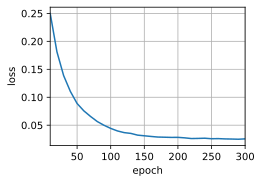

In [44]:
params_rng, dropout_rng = jax.random.split(rng)
rngs = {"params": params_rng, "dropout": dropout_rng}

init_x = init_dec_input = jnp.ones((batch_size, num_steps), dtype=jnp.int32)
init_x_valid_len = jnp.ones((batch_size,), dtype=jnp.int32)
params = net.init(rngs, init_x, init_dec_input, init_x_valid_len)["params"]

state = create_train_state(net, params, lr)
# Set the seed for the data iterator
random.seed(0)
state = train_seq2seq(state, train_iter, num_epochs, tgt_vocab, rngs)

# Prediction

We use greedy decoding, where the inputs to the decoder are "bos" (beginning of sentence), followed by the most likely target token from the previous step, as shown below. We keep decoding until the model generates "eos" (end of sentence).


<img src="https://github.com/probml/probml-notebooks/blob/main/images/seq2seq-predict.png?raw=true">


In [45]:
def predict_seq2seq(net, state, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(" ")] + [src_vocab["<eos>"]]
    enc_valid_len = jnp.array([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab["<pad>"])
    # Add the batch axis
    enc_X = jnp.expand_dims(jnp.array(src_tokens, dtype=jnp.int32), axis=0)
    enc_outputs = net.encoder.apply({"params": state.params["encoder"]}, enc_X, enc_valid_len, deterministic=True)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = jnp.expand_dims(jnp.array([tgt_vocab["<bos>"]], dtype=jnp.int32), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        dec_state, Y = net.decoder.apply({"params": state.params["decoder"]}, dec_state, dec_X, deterministic=True)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(axis=2)
        pred = dec_X.squeeze(axis=0).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab["<eos>"]:
            break
        output_seq.append(pred)
    return " ".join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# Evaluation

In the MT community, the standard evaluation metric is known as BLEU (Bilingual Evaluation Understudy), which measures how many n-grams in the predicted target match the true label target.

For example, suppose the prediction is A,B,B,C,D and the target is A,B,C,D,E,F.
There are five 1-grams in the prediction, of which 4 find a match in the target (the second "B" is a "false positive"), so the precision for 1-grams is $p_1=4/5$. Similarly, there are four 2-grams, of which 3 find a match (the bigram "BB" does not occur), so $p_2 = 3/4$. We continue in this way to compute up to $p_k$, where $k$ is the max n-gram length. (Since we are using words, not characters, we typically keep $k$ small, to avoid sparse counts.)

The BLEU score is then defined by
$$
\exp(\min(0, 1-\frac{L_y}{L_p})) \prod_{n=1}^k p_n^{0.5^n}
$$
where $L_y$ is the length of the target label sequence, and $L_p$ is the length of the prediction.

Since predicting shorter sequences tends to give higher $p_n$ values, short sequences are penalized by the exponential factor. For example, suppose  $k=2$ and the label sequence  is A,B,C,D,E,F.
If the predicted sequence is A,B,B,C,D,
we have $p_1=4/5$ and $p_2=3/4$, and the penalty factor is
$\exp(1-6/5)=0.818$.
If  the predicted sequence  is A,B,
we have $p_1=p_2=1$, but the penalty factor is $\exp(1−6/2)≈0.135$.



In [48]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    # Add a small epsilon to len_pred to avoid log(0) when computing the brevity penalty
    # if len_pred is 0, but this doesn't fix the n-gram matching issue.
    # The n-gram issue is handled below by checking len_pred - n + 1 > 0.
    score = math.exp(min(0, 1 - len_label / (len_pred + 1e-9))) # Add epsilon for brevity penalty

    for n in range(1, k + 1):
        # Ensure that we only compute n-gram matches if the predicted sequence is long enough
        if len_pred - n + 1 > 0:
            num_matches, label_subs = 0, collections.defaultdict(int)
            for i in range(len_label - n + 1):
                label_subs["".join(label_tokens[i : i + n])] += 1
            for i in range(len_pred - n + 1):
                if label_subs["".join(pred_tokens[i : i + n])] > 0:
                    num_matches += 1
                    label_subs["".join(pred_tokens[i : i + n])] -= 1
            score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
        else:
            # If the predicted sequence is too short for this n-gram length,
            # there are no possible matches. The term becomes 0/something,
            # but to avoid issues with pow(0, 0) or similar, we can effectively
            # treat the precision for this n-gram as 0, which means the score
            # should be multiplied by 0^something. However, the BLEU formula
            # takes the geometric mean of precisions. If one precision is 0,
            # the overall score will be 0. A simpler way is to just stop the loop
            # or multiply by 0 raised to the power. A more robust approach is
            # to just not update the score for this n when the length is insufficient.
            # But according to the BLEU definition, if the predicted sequence
            # is shorter than n, the precision for that n is 0. Multiplying by 0
            # will make the overall score 0. Let's keep the power term as if
            # num_matches is 0.
            if len_pred - n + 1 <= 0:
                 # If the denominator is non-positive, this precision is effectively 0.
                 # The power of 0 is tricky. If the exponent is positive, 0^x is 0.
                 # If the exponent is 0, 0^0 is 1.
                 # The exponent math.pow(0.5, n) is always positive for n >= 1.
                 score *= 0.0 # This effectively makes the BLEU score 0.

    return score

In [49]:
# prediction

engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]

data = []
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, state, eng, src_vocab, tgt_vocab, num_steps)
    score = bleu(translation, fra, k=2)
    data.append((eng, fra, translation, score))
df = pd.DataFrame.from_records(data, columns=["English", "Truth", "Prediction", "Bleu"])
display.display(df)

,English,Truth,Prediction,Bleu
0,go .,va !,,0.0
1,i lost .,j'ai perdu .,j'en ai,0.0
2,he's calm .,il est calme .,je suis chez ai ai,0.0
3,i'm home .,je suis chez moi .,faible faible faible faible gras faible gras,0.0
